- Libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
from copy import deepcopy as dc

In [3]:
%pip install deep

Note: you may need to restart the kernel to use updated packages.


- Stats for time series Data

In [4]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller

- Quality metrics

In [5]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

- DateTime and warning

In [6]:
import warnings
warnings.filterwarnings("ignore")
from DateTime import DateTime

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## EDA
- Analisis exploratorio para poder ver la distribucion de los datos y determinar sus propiedades
    - Dejaremos esto para otro momento

- Selection of Data

In [8]:
df= pd.read_csv('../Data/apple.csv',sep=',',encoding='utf-8')

In [9]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,05/29/2024,$190.29,53068020,$189.61,$192.247,$189.51
1,05/28/2024,$189.99,52280050,$191.51,$193.00,$189.10
2,05/24/2024,$189.98,36326980,$188.82,$190.58,$188.0404
3,05/23/2024,$186.88,51005920,$190.98,$191.00,$186.625
4,05/22/2024,$190.90,34648550,$192.265,$192.8231,$190.27


- Only working with closing values

In [10]:
df= df[['Date','Close/Last']]
df['Close/Last']=df['Close/Last'].str.replace('$','',regex=False).astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        2517 non-null   object 
 1   Close/Last  2517 non-null   float64
dtypes: float64(1), object(1)
memory usage: 39.5+ KB


- Passing Date to datetime

In [11]:
df['Date']= pd.to_datetime(df['Date'])

- Organizing the Data

In [12]:
df.sort_values(by='Date',inplace=True)
df.reset_index(inplace=True)
df.drop(columns='index',inplace=True)

- Plotting the Data

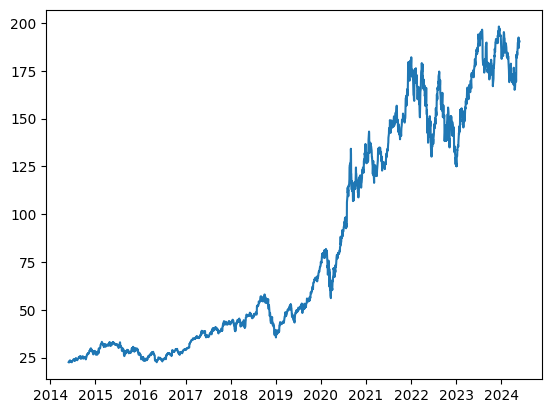

In [13]:
plt.plot(df['Date'], df['Close/Last'])

- Setting the Data datetimeindex

In [14]:
df.set_index('Date',inplace=True)

- In order to work with this Algorithm and apply many different transformations trough the datetimeindex, is necessary to set the frequency of the data to 'Daily, if the data is not inferedl those manipulations and transformations are going to be more difficult to set

- Function to create shifts or time-steps

In [15]:
def transform_df(df,n_steps):
    
    for i in range(1,n_steps+1):
        df[f'Close (t-{i})']= df['Close/Last'].shift(i)
        
    df.dropna(inplace=True)
    return df
     

- Transformation of the data

In [16]:
lookback= 7

In [17]:
data= transform_df(df,lookback)
data.head()

,Close/Last,Close (t-1),Close (t-2),Close (t-3),Close (t-4),Close (t-5),Close (t-6),Close (t-7)
Date,,,,,,,,
2014-06-10,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693,22.4518,22.6072
2014-06-11,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693,22.4518
2014-06-12,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293,22.7693
2014-06-13,22.8200,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197,23.0293
2014-06-16,23.0500,22.8200,23.0725,23.4650,23.5625,23.4250,23.0561,23.1197


In [18]:
df=df.asfreq('D')
df.ffill(inplace=True)
freq= pd.infer_freq(df.index)
print(freq)

D


- Head para corroborar cambios efectuados

- Transforma todos los datos del dataset a arrays

In [19]:
data_array= df.to_numpy()
data_array

array([[ 23.5625,  23.425 ,  23.0561, ...,  22.7693,  22.4518,  22.6072],
       [ 23.465 ,  23.5625,  23.425 , ...,  23.0293,  22.7693,  22.4518],
       [ 23.0725,  23.465 ,  23.5625, ...,  23.1197,  23.0293,  22.7693],
       ...,
       [189.98  , 186.88  , 190.9   , ..., 189.87  , 189.84  , 189.72  ],
       [189.99  , 189.98  , 186.88  , ..., 191.04  , 189.87  , 189.84  ],
       [190.29  , 189.99  , 189.98  , ..., 192.35  , 191.04  , 189.87  ]])

- Escalado de valores del array entre -1,1 para alimentar el modelo

In [20]:
scaler= MinMaxScaler(feature_range=(-1,1))
transformed= scaler.fit_transform(data)
transformed

array([[-0.98869204, -0.99025863, -0.99446166, ..., -0.99772929,
        -1.        , -0.99823065],
       [-0.98980289, -0.98869204, -0.99025863, ..., -0.994767  ,
        -0.99638503, -1.        ],
       [-0.99427481, -0.98980289, -0.98869204, ..., -0.99373704,
        -0.99342473, -0.99638503],
       ...,
       [ 0.90737154,  0.87205195,  0.91785348, ...,  0.90611826,
         0.90583986,  0.90447357],
       [ 0.90748547,  0.90737154,  0.87205195, ...,  0.91944856,
         0.90618144,  0.90583986],
       [ 0.9109035 ,  0.90748547,  0.90737154, ...,  0.93437393,
         0.91950276,  0.90618144]])

- Haciendo Slicing para dividir el dato de entrenamiento y el target

In [21]:
X= transformed[:,1:]
y= transformed[:,0]

- Imprimir shape para comparar resultados

In [22]:
print(X.shape)
print(y.shape)

(2510, 7)
(2510,)


- Al haber creado las diferencias en el tiempo o los lags, no se tomo en consideracion que los datos tienen que estar en una secuencia que permita el dato mas reciente, hay que invertir la matrix (espejo, para tener el resultado esperado)

In [23]:
X= dc(np.flip(X,axis=1))

In [24]:
X.shape

(2510, 7)

In [25]:
split_index= int(len(X) * 0.90)
split_index

2259

- Dividing x and y

In [26]:
X_train= X[:split_index]
X_test= X[split_index:]
y_train= y[:split_index]
y_test= y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2259, 7), (251, 7), (2259,), (251,))

- Torch only work with tensors, so tge data has to be reshaped

In [27]:
X_train= X_train.reshape((-1,lookback,1))
X_test= X_test.reshape((-1,lookback,1))

y_train= y_train.reshape((-1,1))
y_test= y_test.reshape((-1,1))

In [28]:
X_train= torch.tensor(X_train).float()
X_test= torch.tensor(X_test).float()
y_train= torch.tensor(y_train).float()
y_test= torch.tensor(y_test).float()

In [29]:
from torch.utils.data import Dataset

In [30]:
class TimeSeries(Dataset):
    def __init__(self,X,y):
        self.X= X
        self.y= y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self,i):
        return self.X[i],self.y[i]
    
train_dataset= TimeSeries(X_train,y_train)
test_dataset= TimeSeries(X_test,y_test)

In [31]:
from torch.utils.data import DataLoader
batch_size =16
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [32]:
for _,batch in enumerate(train_loader):
    x_batch,y_batch= batch[0].to(device),batch[1].to(device)
    print(x_batch.shape,y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [33]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_stacked_layers):
        super().__init__()
        self.hidden_size= hidden_size
        self.num_stacked_layers= num_stacked_layers
        
        self.lstm= nn.LSTM(input_size,hidden_size,num_stacked_layers,
                           batch_first=True)
        self.fc= nn.Linear(hidden_size,1)
        
    def forward(self,x):
        batch_size= x.size(0)
        h0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        c0= torch.zeros(self.num_stacked_layers,batch_size,self.hidden_size).to(device)
        
        out,_ = self.lstm(x,(h0,c0))
        out= self.fc(out[:,-1,:])
        return out
    
model= LSTM(1,4,1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [34]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [35]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [36]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.304

Val Loss: 0.555
***************************************************

Epoch: 2
Batch 100, Loss: 0.052

Val Loss: 0.069
***************************************************

Epoch: 3
Batch 100, Loss: 0.004

Val Loss: 0.054
***************************************************

Epoch: 4
Batch 100, Loss: 0.004

Val Loss: 0.048
***************************************************

Epoch: 5
Batch 100, Loss: 0.003

Val Loss: 0.043
***************************************************

Epoch: 6
Batch 100, Loss: 0.003

Val Loss: 0.036
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.031
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.027
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.024
***************************************************

Epoch: 10
Batch 100, Loss: 0.001

Val Loss: 0.017
********************************

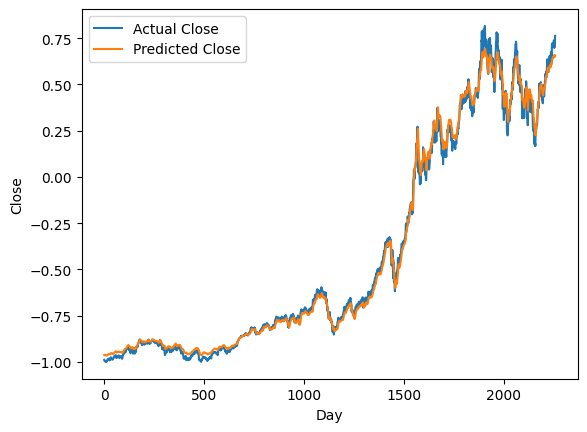

In [37]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [38]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 25.79885544,  25.9142414 ,  25.99365556, ..., 167.28427754,
       167.40356096, 167.97461054])

In [39]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 23.56249919,  23.46499973,  23.07250124, ..., 172.99000219,
       175.4299998 , 177.29999935])

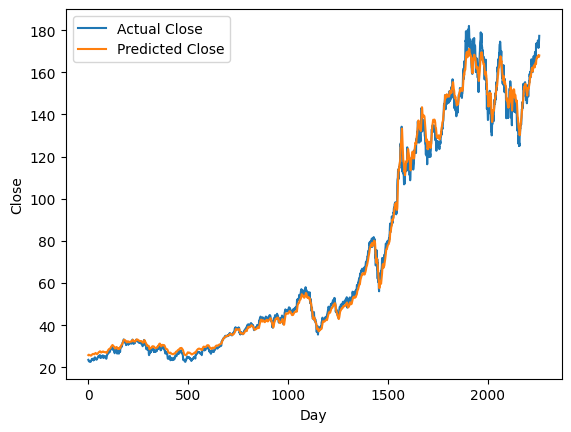

In [40]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [41]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([168.62761679, 168.97941422, 169.83448191, 170.54144062,
       170.71910758, 170.81390236, 170.57772107, 171.02007576,
       171.30252443, 172.00716035, 172.25691737, 172.59701717,
       173.21645289, 173.37955535, 173.52199863, 173.41432913,
       173.93623923, 174.1170294 , 173.98119351, 174.44505489,
       174.88615402, 175.2050767 , 176.22492617, 176.42406321,
       176.4330143 , 176.59868543, 176.4647015 , 176.038554  ,
       175.73627271, 175.80051553, 175.92753111, 176.01986185,
       176.65477757, 176.91068161, 177.36763741, 177.28880918,
       177.09717411, 177.1548357 , 177.32096721, 177.51325098,
       177.38514201, 177.78398108, 178.07139444, 178.11895924,
       177.65770838, 177.2127641 , 175.2663271 , 173.69237288,
       172.85840382, 171.87986227, 171.19195145, 170.68397806,
       170.66196914, 170.28801108, 169.97220638, 169.21636977,
       168.92494384, 168.99759891, 169.29248809, 170.21541879,
       169.72632066, 170.05617718, 170.57542444, 171.67

In [42]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([177.25000191, 180.08999998, 180.95000098, 179.580002  ,
       179.20999896, 177.81999996, 180.57000054, 180.95999838,
       183.78999905, 183.30999849, 183.94999924, 186.01000163,
       184.91999775, 185.01000047, 183.96000186, 187.00000017,
       186.67999979, 185.27000077, 188.0600014 , 189.25000017,
       189.59000056, 193.97000042, 192.46000128, 191.33000258,
       191.80999791, 190.67999921, 188.60999942, 188.08000142,
       189.77000077, 190.53999905, 190.69000184, 193.99000044,
       193.73000014, 195.09999912, 193.12999944, 191.94000068,
       192.749999  , 193.6199974 , 194.49999842, 193.22000216,
       195.83000258, 196.44999807, 195.60500101, 192.58000142,
       191.1700024 , 181.99000219, 178.84999854, 179.80000226,
       178.18999777, 177.96999752, 177.79000254, 179.46000187,
       177.45000214, 176.57000112, 174.00000075, 174.4899987 ,
       175.83999766, 177.23000189, 181.11999856, 176.37999829,
       178.60999826, 180.1900001 , 184.12000205, 187.64

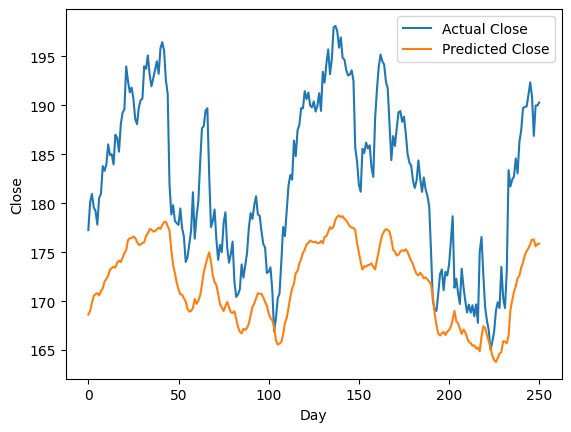

In [43]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()